In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

import statsmodels.api as sm
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [4]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from spglm.family import Gaussian

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [6]:
import folium

# Import the datasets

## Gini Index

In [6]:
Gini_index = pd.read_csv('nhgis0024_csv/nhgis0024_ds255_20215_tract.csv', encoding='ISO-8859-1')
Gini_index = Gini_index[['YEAR','STATE','COUNTY','NAME_E','GEO_ID','AO72E001']]
Gini_index = Gini_index.rename(columns={'NAME_E':'Tract_name','AO72E001':'Gini_index'})
Gini_index.info()
Gini_index

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   YEAR        85395 non-null  object 
 1   STATE       85395 non-null  object 
 2   COUNTY      85395 non-null  object 
 3   Tract_name  85395 non-null  object 
 4   GEO_ID      85395 non-null  object 
 5   Gini_index  84186 non-null  float64
dtypes: float64(1), object(5)
memory usage: 3.9+ MB


,YEAR,STATE,COUNTY,Tract_name,GEO_ID,Gini_index
0,2017-2021,Alabama,Autauga County,"Census Tract 201, Autauga County, Alabama",1400000US01001020100,0.4607
1,2017-2021,Alabama,Autauga County,"Census Tract 202, Autauga County, Alabama",1400000US01001020200,0.3975
2,2017-2021,Alabama,Autauga County,"Census Tract 203, Autauga County, Alabama",1400000US01001020300,0.3673
3,2017-2021,Alabama,Autauga County,"Census Tract 204, Autauga County, Alabama",1400000US01001020400,0.5569
4,2017-2021,Alabama,Autauga County,"Census Tract 205.01, Autauga County, Alabama",1400000US01001020501,0.3598
...,...,...,...,...,...,...
85390,2017-2021,Puerto Rico,Yauco Municipio,"Census Tract 7505.01, Yauco Municipio, Puerto ...",1400000US72153750501,0.5313
85391,2017-2021,Puerto Rico,Yauco Municipio,"Census Tract 7505.02, Yauco Municipio, Puerto ...",1400000US72153750502,0.5726
85392,2017-2021,Puerto Rico,Yauco Municipio,"Census Tract 7505.03, Yauco Municipio, Puerto ...",1400000US72153750503,0.4791
85393,2017-2021,Puerto Rico,Yauco Municipio,"Census Tract 7506.01, Yauco Municipio, Puerto ...",1400000US72153750601,0.4409


## Race and Edu

Simpson's Diversity Index \( D \) is given by the formula:

$$ D = 1 - \sum_{i=1}^{n} p_i^2 $$

Where \( p_i \) is the proportion of type \( i \) in the dataset, and \( n \) is the number of types.

This formula calculates the probability of diversity. A value closer to 1 indicates higher diversity, while a smaller value signifies greater concentration and lower diversity.

In [7]:
independent_data = pd.read_csv('nhgis0024_csv/nhgis0024_ds254_20215_tract.csv', encoding='ISO-8859-1')

# select the useful columns
independent_data = independent_data[['GEO_ID',
                                     'AON5E001','AON5E002','AON5E003','AON5E004','AON5E005','AON5E006','AON5E007',   # Race
                                     'AORME001',                                                                     # Percaptia income
                                     'AOP8E001',                                                                     # Total Educational Attainment
                                     'AOP8E003','AOP8E004','AOP8E005','AOP8E006','AOP8E007','AOP8E008','AOP8E009','AOP8E010','AOP8E011','AOP8E012','AOP8E013','AOP8E014','AOP8E015','AOP8E016',# less_high
                                     'AOP8E017','AOP8E018',                                                          # high_equi
                                     'AOP8E019','AOP8E020','AOP8E021',                                               # college
                                     'AOP8E022','AOP8E023','AOP8E024','AOP8E025',                                    # Educational ba ma pro doc
                                    ]]                                                                    

# create the new columns to record the classification of edu attainment
independent_data['less_high'] = (independent_data['AOP8E003'] + independent_data['AOP8E004'] + independent_data['AOP8E005'] + 
                                 independent_data['AOP8E006'] + independent_data['AOP8E007'] + independent_data['AOP8E008'] + 
                                 independent_data['AOP8E009'] + independent_data['AOP8E010'] + independent_data['AOP8E011'] + 
                                 independent_data['AOP8E012'] + independent_data['AOP8E013'] + independent_data['AOP8E014'] + 
                                 independent_data['AOP8E015'] + independent_data['AOP8E016'])
independent_data['high_equi'] = (independent_data['AOP8E017'] + independent_data['AOP8E018'])
independent_data['col'] = (independent_data['AOP8E019'] + independent_data['AOP8E020'] + independent_data['AOP8E021'])
independent_data['ba_higher'] = (independent_data['AOP8E022'] + independent_data['AOP8E023'] + independent_data['AOP8E024'] + independent_data['AOP8E025'])

# change the columns' name
independent_data = independent_data.rename(columns={'AON5E001':'totalpop','AON5E002':'white','AON5E003':'black','AON5E004':'amer_alska','AON5E005':'asia','AON5E006':'hawai_paci','AON5E007':'some_other',   # Race
                                                    'AOP8E001':'totaledu','AOP8E022':'ba','AOP8E023':'ma','AOP8E024':'pro','AOP8E025':'doc',                                                                 # Educational Attainment for the Population 25 Years and Over
                                                    'AORME001':'per_inc'})                                                                                                                                    # Percaptia income

# calculate the edu_sdi
def edu_SDI(row):
    proportions = [row[edu] / row['totaledu'] for edu in ['less_high', 'high_equi', 'col', 'ba_higher'] if row[edu] > 0]
    return 1 - sum(p ** 2 for p in proportions)
independent_data['edu_sdi'] = independent_data.apply(edu_SDI, axis=1)

# create the new columns to record the educational attainment ratio
independent_data['totaledu_ra'] = independent_data['totaledu'] / independent_data['totalpop'] 
independent_data['less_high_ra'] = independent_data['less_high'] / independent_data['totaledu'] 
independent_data['high_equi_ra'] = independent_data['high_equi'] / independent_data['totaledu'] 
independent_data['col_ra'] = independent_data['col'] / independent_data['totaledu'] 
independent_data['ba_higher_ra'] = independent_data['ba_higher'] / independent_data['totaledu'] 

# calculate the race_sdi
def race_SDI(row):
    proportions = [row[race] / row['totalpop'] for race in ['white', 'black', 'amer_alska', 'asia', 'hawai_paci','some_other'] if row[race] > 0]
    return 1 - sum(p ** 2 for p in proportions)
independent_data['race_sdi'] = independent_data.apply(race_SDI, axis=1)

# create the race ratio
independent_data['white_ra'] = independent_data['white'] / independent_data['totalpop'] 
independent_data['black_ra'] = independent_data['black'] / independent_data['totalpop'] 
independent_data['amer_alska_ra'] = independent_data['amer_alska'] / independent_data['totalpop'] 
independent_data['asia_ra'] = independent_data['asia'] / independent_data['totalpop'] 
independent_data['hawai_paci_ra'] = independent_data['hawai_paci'] / independent_data['totalpop'] 
independent_data['some_other_ra'] = independent_data['some_other'] / independent_data['totalpop'] 

# filiter the useful data
independent_data = independent_data[['GEO_ID','totalpop','white','black','amer_alska','asia','hawai_paci','some_other', 'white_ra','black_ra','amer_alska_ra','asia_ra','hawai_paci_ra','some_other_ra',  # Race
                                     'totaledu','less_high','high_equi','col','ba_higher','totaledu_ra','less_high_ra','high_equi_ra','col_ra','ba_higher_ra',                                            # Educational Attainment for the Population 25 Years and Over
                                     'per_inc','race_sdi','edu_sdi']]                                                                                                                                     # Percaptia income          

hispan_ra = pd.read_csv('nhgis0034_csv/ACSDT5Y2021.B03003-Data.csv')
hispan_ra = hispan_ra.drop(hispan_ra.index[0]).reset_index(drop=True)
hispan_ra['hispan_ra'] = hispan_ra['B03003_003E'].astype(float) / hispan_ra['B03003_001E'].astype(float)
hispan_ra = hispan_ra[['GEO_ID','hispan_ra']]

independent_data = independent_data.merge(hispan_ra,on='GEO_ID',how='left')
independent_data.info()
independent_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEO_ID         85395 non-null  object 
 1   totalpop       85395 non-null  int64  
 2   white          85395 non-null  int64  
 3   black          85395 non-null  int64  
 4   amer_alska     85395 non-null  int64  
 5   asia           85395 non-null  int64  
 6   hawai_paci     85395 non-null  int64  
 7   some_other     85395 non-null  int64  
 8   white_ra       84524 non-null  float64
 9   black_ra       84524 non-null  float64
 10  amer_alska_ra  84524 non-null  float64
 11  asia_ra        84524 non-null  float64
 12  hawai_paci_ra  84524 non-null  float64
 13  some_other_ra  84524 non-null  float64
 14  totaledu       85395 non-null  int64  
 15  less_high      85395 non-null  int64  
 16  high_equi      85395 non-null  int64  
 17  col            85395 non-null  int64  
 18  ba_hig

,GEO_ID,totalpop,white,black,amer_alska,asia,hawai_paci,some_other,white_ra,black_ra,amer_alska_ra,asia_ra,hawai_paci_ra,some_other_ra,totaledu,less_high,high_equi,col,ba_higher,totaledu_ra,less_high_ra,high_equi_ra,col_ra,ba_higher_ra,per_inc,race_sdi,edu_sdi,hispan_ra
0,1400000US01001020100,1791,1502,171,0,38,0,0,0.8386,0.0955,0.0000,0.0212,0.0000,0.0000,1225,184,452,320,269,0.6840,0.1502,0.3690,0.2612,0.2196,30934.0000,0.2871,0.7248,0.0156
1,1400000US01001020200,2010,785,1088,0,0,0,8,0.3905,0.5413,0.0000,0.0000,0.0000,0.0040,1480,152,757,285,286,0.7363,0.1027,0.5115,0.1926,0.1932,26446.0000,0.5545,0.6534,0.0050
2,1400000US01001020300,3577,2433,983,0,26,0,7,0.6802,0.2748,0.0000,0.0073,0.0000,0.0020,2415,263,788,960,390,0.6751,0.1089,0.3263,0.3975,0.1615,25683.0000,0.4618,0.6976,0.0036
3,1400000US01001020400,3802,3410,251,18,14,0,0,0.8969,0.0660,0.0047,0.0037,0.0000,0.0000,2886,189,841,821,1035,0.7591,0.0655,0.2914,0.2845,0.3586,47804.0000,0.1912,0.7013,0.0074
4,1400000US01001020501,4381,3323,976,0,28,0,0,0.7585,0.2228,0.0000,0.0064,0.0000,0.0000,3000,279,774,791,1156,0.6848,0.0930,0.2580,0.2637,0.3853,30313.0000,0.3750,0.7068,0.0217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85390,1400000US72153750501,4757,3512,70,0,0,0,743,0.7383,0.0147,0.0000,0.0000,0.0000,0.1562,3506,474,1544,415,1010,0.7370,0.1352,0.4404,0.1184,0.2881,12345.0000,0.4303,0.6908,0.9958
85391,1400000US72153750502,2871,1911,217,35,0,0,535,0.6656,0.0756,0.0122,0.0000,0.0000,0.1863,1703,165,500,343,667,0.5932,0.0969,0.2936,0.2014,0.3917,10680.0000,0.5164,0.7104,1.0000
85392,1400000US72153750503,2010,1490,21,0,0,0,397,0.7413,0.0104,0.0000,0.0000,0.0000,0.1975,1504,245,501,253,424,0.7483,0.1629,0.3331,0.1682,0.2819,10123.0000,0.4114,0.7547,1.0000
85393,1400000US72153750601,4927,3197,442,0,0,0,829,0.6489,0.0897,0.0000,0.0000,0.0000,0.1683,3208,263,918,701,1244,0.6511,0.0820,0.2862,0.2185,0.3878,11622.0000,0.5426,0.7133,0.9921


## Labor force and Unemploy

Explation:  

- **Labor Force Participation Rate（劳动力参与率）** = 劳动力总人数 / 16岁及以上的人口总数
- **Employment/Population Ratio（就业/人口比率）** = 就业人数 / 16岁及以上的人口总数，其中“就业人数” < "劳动力总人数"
- **Unemployment Rate（失业率）** = 失业人数 / 劳动力总数
数100%

In [8]:
employment_data = pd.read_csv('acs_employment/ACSST5Y2021.S2301-Data.csv')
employment_data = employment_data[['GEO_ID','S2301_C02_001E','S2301_C03_001E','S2301_C04_001E']]
employment_data = employment_data.drop(employment_data.index[0]).reset_index(drop=True)

employment_data = employment_data.rename(columns={'S2301_C02_001E':'laborforce_partici_ra','S2301_C03_001E':'employ_ra','S2301_C04_001E':'unemply_ra'})
employment_data = employment_data[(employment_data['laborforce_partici_ra'] != "-") & (employment_data['employ_ra'] != "-") & (employment_data['unemply_ra'] != "-")]
employment_data[['laborforce_partici_ra', 'employ_ra', 'unemply_ra']] = employment_data[['laborforce_partici_ra', 'employ_ra', 'unemply_ra']].astype(float)
employment_data['laborforce_partici_ra'] = employment_data['laborforce_partici_ra'] / 100
employment_data['employ_ra'] = employment_data['employ_ra'] / 100
employment_data['unemply_ra'] = employment_data['unemply_ra'] / 100

employment_data.info()
employment_data

<class 'pandas.core.frame.DataFrame'>
Index: 84375 entries, 0 to 85394
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GEO_ID                 84375 non-null  object 
 1   laborforce_partici_ra  84375 non-null  float64
 2   employ_ra              84375 non-null  float64
 3   unemply_ra             84375 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.2+ MB


,GEO_ID,laborforce_partici_ra,employ_ra,unemply_ra
0,1400000US01001020100,0.5340,0.5210,0.0250
1,1400000US01001020200,0.5940,0.5370,0.0450
2,1400000US01001020300,0.6720,0.6490,0.0240
3,1400000US01001020400,0.5720,0.5570,0.0220
4,1400000US01001020501,0.6850,0.6490,0.0100
...,...,...,...,...
85390,1400000US72153750501,0.5000,0.4460,0.1080
85391,1400000US72153750502,0.4250,0.3490,0.1800
85392,1400000US72153750503,0.3990,0.3010,0.2470
85393,1400000US72153750601,0.4750,0.3920,0.1750


## Household Type

In [9]:
singlefaimly_data = pd.read_csv('nhgis0026_csv/nhgis0026_ds254_20215_tract.csv', encoding='ISO-8859-1')
singlefaimly_data = singlefaimly_data[['GEO_ID','AOO1E001','AOO1E004']]
singlefaimly_data = singlefaimly_data.rename(columns={'AOO1E001':'totalfami','AOO1E004':'sinfami'})
singlefaimly_data['sinfami_ra'] = singlefaimly_data['sinfami'] / singlefaimly_data['totalfami']
singlefaimly_data.info()
singlefaimly_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GEO_ID      85395 non-null  object 
 1   totalfami   85395 non-null  int64  
 2   sinfami     85395 non-null  int64  
 3   sinfami_ra  84272 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.6+ MB


,GEO_ID,totalfami,sinfami,sinfami_ra
0,1400000US01001020100,609,124,0.2036
1,1400000US01001020200,600,216,0.3600
2,1400000US01001020300,1346,321,0.2385
3,1400000US01001020400,1606,191,0.1189
4,1400000US01001020501,1789,284,0.1587
...,...,...,...,...
85390,1400000US72153750501,1688,408,0.2417
85391,1400000US72153750502,886,282,0.3183
85392,1400000US72153750503,635,172,0.2709
85393,1400000US72153750601,1473,280,0.1901


## Occupation

In [10]:
occu_data = pd.read_csv('nhgis0027_csv/nhgis0027_ds254_20215_tract.csv', encoding='ISO-8859-1')
occu_data = occu_data[['GEO_ID',
                       'AOXYE001',                                              # total
                       'AOXYE003','AOXYE019','AOXYE027','AOXYE030','AOXYE034',  # male
                       'AOXYE039','AOXYE055','AOXYE063','AOXYE066','AOXYE070']] # female
occu_data['manage_busi_sci_arts'] = (occu_data['AOXYE003'] + occu_data['AOXYE039'])
occu_data['serve'] = (occu_data['AOXYE019'] + occu_data['AOXYE055'])
occu_data['sale_office'] = (occu_data['AOXYE027'] + occu_data['AOXYE063'])
occu_data['nature'] = (occu_data['AOXYE030'] + occu_data['AOXYE066'])
occu_data['product_trans'] = (occu_data['AOXYE034'] + occu_data['AOXYE070'])

occu_data = occu_data.rename(columns={'AOXYE001':'Totaloccupa'})

# calculate the occu_SDI
def occu_SDI(row):
    proportions = [row[occu] / row['Totaloccupa'] for occu in ['manage_busi_sci_arts', 'serve', 'sale_office', 'nature', 'product_trans'] if row[occu] > 0]
    return 1 - sum(p ** 2 for p in proportions)
occu_data['occu_sdi'] = occu_data.apply(occu_SDI, axis=1)

# create the ratio
occu_data['manage_busi_sci_arts_ra'] = occu_data['manage_busi_sci_arts'] / occu_data['Totaloccupa']
occu_data['serve_ra'] = occu_data['serve'] / occu_data['Totaloccupa']
occu_data['sale_office_ra'] = occu_data['sale_office'] / occu_data['Totaloccupa']
occu_data['nature_ra'] = occu_data['nature'] / occu_data['Totaloccupa']
occu_data['product_trans_ra'] = occu_data['product_trans'] / occu_data['Totaloccupa']
                                                               
occu_data = occu_data[['GEO_ID','Totaloccupa','manage_busi_sci_arts','serve','sale_office','nature','product_trans','manage_busi_sci_arts_ra','serve_ra','sale_office_ra','nature_ra','product_trans_ra','occu_sdi']]
occu_data.info()
occu_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   GEO_ID                   85395 non-null  object 
 1   Totaloccupa              85395 non-null  int64  
 2   manage_busi_sci_arts     85395 non-null  int64  
 3   serve                    85395 non-null  int64  
 4   sale_office              85395 non-null  int64  
 5   nature                   85395 non-null  int64  
 6   product_trans            85395 non-null  int64  
 7   manage_busi_sci_arts_ra  84372 non-null  float64
 8   serve_ra                 84372 non-null  float64
 9   sale_office_ra           84372 non-null  float64
 10  nature_ra                84372 non-null  float64
 11  product_trans_ra         84372 non-null  float64
 12  occu_sdi                 85395 non-null  float64
dtypes: float64(6), int64(6), object(1)
memory usage: 8.5+ MB


,GEO_ID,Totaloccupa,manage_busi_sci_arts,serve,sale_office,nature,product_trans,manage_busi_sci_arts_ra,serve_ra,sale_office_ra,nature_ra,product_trans_ra,occu_sdi
0,1400000US01001020100,742,193,66,316,75,92,0.2601,0.0889,0.4259,0.1011,0.1240,0.7175
1,1400000US01001020200,906,380,120,210,46,150,0.4194,0.1325,0.2318,0.0508,0.1656,0.7228
2,1400000US01001020300,1820,598,263,434,187,338,0.3286,0.1445,0.2385,0.1027,0.1857,0.7692
3,1400000US01001020400,1800,803,103,318,140,436,0.4461,0.0572,0.1767,0.0778,0.2422,0.7018
4,1400000US01001020501,2455,1156,383,570,99,247,0.4709,0.1560,0.2322,0.0403,0.1006,0.6883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85390,1400000US72153750501,1713,755,277,393,90,198,0.4407,0.1617,0.2294,0.0525,0.1156,0.7108
85391,1400000US72153750502,692,286,99,185,32,90,0.4133,0.1431,0.2673,0.0462,0.1301,0.7182
85392,1400000US72153750503,507,110,136,124,60,77,0.2170,0.2682,0.2446,0.1183,0.1519,0.7841
85393,1400000US72153750601,1551,580,289,433,35,214,0.3740,0.1863,0.2792,0.0226,0.1380,0.7280


## Foreign Born and Native American

In [11]:
born = pd.read_csv('nhgis0034_csv/nhgis0034_ds255_20215_tract.csv', encoding='ISO-8859-1')
born = born.drop(born.index[0]).reset_index(drop=True)
born = born[['GEO_ID','AOYWE001','AOYUE002','AOYWE013']]
born['fore_born_ra'] = born['AOYWE013'].astype(float) / born['AOYWE001'].astype(float)
born['nati_ameri_ra'] = born['AOYUE002'].astype(float) / born['AOYWE001'].astype(float)

born = born[['GEO_ID','fore_born_ra','nati_ameri_ra']]
born.info()
born

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85394 entries, 0 to 85393
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GEO_ID         85394 non-null  object 
 1   fore_born_ra   84523 non-null  float64
 2   nati_ameri_ra  83602 non-null  float64
dtypes: float64(2), object(1)
memory usage: 2.0+ MB


,GEO_ID,fore_born_ra,nati_ameri_ra
0,1400000US01001020200,0.0015,0.9831
1,1400000US01001020300,0.0120,0.9832
2,1400000US01001020400,0.0460,0.9498
3,1400000US01001020501,0.0427,0.9381
4,1400000US01001020502,0.0974,0.8011
...,...,...,...
85389,1400000US72153750501,0.0015,NaN
85390,1400000US72153750502,0.0035,NaN
85391,1400000US72153750503,0.0055,NaN
85392,1400000US72153750601,0.0057,NaN


# Combine Datasets into together

In [12]:
com_data = Gini_index.merge(independent_data,on='GEO_ID',how='left').merge(employment_data,on='GEO_ID',how='left').merge(singlefaimly_data,on='GEO_ID',how='left').merge(born,on='GEO_ID',how='left').reset_index(drop=True)
com_data['GEO_ID'] = com_data['GEO_ID'].str[-11:]
com_data = com_data.dropna()

In [13]:
import requests
import io

### 2010 US Mainland Census Tracts

# the list of the U.S mainland state
states_fips = ['01', '04', '05', '06', '08', '09', '10', '11', '12', '13', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56']

# the fundamental url
base_url = "https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_{0}_tract.zip"

# read the census tract geomertry for each state in 2010
tracts = []

for fips in states_fips:
    url = base_url.format(fips)
    try:
        response = requests.get(url)
        response.raise_for_status()  # if has some problems，which will indicate a "HTTPError"
        with io.BytesIO(response.content) as f:
            tract = gpd.read_file(f)
            tracts.append(tract)
    except requests.RequestException as e:
        print(f"Error downloading data for FIPS {fips}: {e}")

# conbine all census tract into together
census_tracts_2020 = gpd.pd.concat(tracts, ignore_index=True)

In [14]:
com_data = census_tracts_2020[['GEOID','ALAND','geometry']].merge(com_data,left_on='GEOID',right_on='GEO_ID',how='left').drop(columns='GEOID')
com_data['ALAND'] = com_data['ALAND'] / 1000000
com_data['popden'] = com_data['totalpop'] / com_data['ALAND']
com_data = com_data.dropna().reset_index(drop=True)

com_data['log_per_inc'] = np.log(com_data['per_inc'])
com_data['log_popden'] = np.log(com_data['popden'])
com_data['log_gini_index'] = np.log(com_data['Gini_index'])

# com_data.to_file("com_data.shp")
# com_data.to_csv('com_data.csv',index=False)

In [15]:
com_data.columns

Index(['ALAND', 'geometry', 'YEAR', 'STATE', 'COUNTY', 'Tract_name', 'GEO_ID',
       'Gini_index', 'totalpop', 'white', 'black', 'amer_alska', 'asia',
       'hawai_paci', 'some_other', 'white_ra', 'black_ra', 'amer_alska_ra',
       'asia_ra', 'hawai_paci_ra', 'some_other_ra', 'totaledu', 'less_high',
       'high_equi', 'col', 'ba_higher', 'totaledu_ra', 'less_high_ra',
       'high_equi_ra', 'col_ra', 'ba_higher_ra', 'per_inc', 'race_sdi',
       'edu_sdi', 'hispan_ra', 'laborforce_partici_ra', 'employ_ra',
       'unemply_ra', 'totalfami', 'sinfami', 'sinfami_ra', 'fore_born_ra',
       'nati_ameri_ra', 'popden', 'log_per_inc', 'log_popden',
       'log_gini_index'],
      dtype='object')

# Read Geodataframe dataset

In [7]:
com_data = gpd.read_file('com_data.shp')
com_data.columns = ['ALAND10','YEAR', 'STATE', 'COUNTY', 'Tract_name','GEO_ID', 'Gini_index', 'totalpop', 'white', 'black', 'amer_alska', 'asia', 'hawai_paci', 'some_other', 
                    'white_ra', 'black_ra', 'amer_alska_ra','asia_ra', 'hawai_paci_ra', 'some_other_ra', 'totaledu', 'less_high', 'high_equi', 'col', 'ba_higher', 'totaledu_ra', 'less_high_ra',
                    'high_equi_ra', 'col_ra', 'ba_higher_ra', 'per_inc', 'race_sdi', 'edu_sdi', 'hispan_ra', 'laborforce_partici_ra', 'employ_ra', 'unemply_ra', 'totalfami', 'sinfami', 'sinfami_ra', 
                    'fore_born_ra', 'nati_ameri_ra', 'popden', 'log_per_inc', 'log_popden', 'log_gini_index', 'geometry']
com_data.info()
com_data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82660 entries, 0 to 82659
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ALAND10                82660 non-null  float64 
 1   YEAR                   82660 non-null  object  
 2   STATE                  82660 non-null  object  
 3   COUNTY                 82660 non-null  object  
 4   Tract_name             82660 non-null  object  
 5   GEO_ID                 82660 non-null  object  
 6   Gini_index             82660 non-null  float64 
 7   totalpop               82660 non-null  float64 
 8   white                  82660 non-null  float64 
 9   black                  82660 non-null  float64 
 10  amer_alska             82660 non-null  float64 
 11  asia                   82660 non-null  float64 
 12  hawai_paci             82660 non-null  float64 
 13  some_other             82660 non-null  float64 
 14  white_ra               82660 n

,ALAND10,YEAR,STATE,COUNTY,Tract_name,GEO_ID,Gini_index,totalpop,white,black,amer_alska,asia,hawai_paci,some_other,white_ra,black_ra,amer_alska_ra,asia_ra,hawai_paci_ra,some_other_ra,totaledu,less_high,high_equi,col,ba_higher,totaledu_ra,less_high_ra,high_equi_ra,col_ra,ba_higher_ra,per_inc,race_sdi,edu_sdi,hispan_ra,laborforce_partici_ra,employ_ra,unemply_ra,totalfami,sinfami,sinfami_ra,fore_born_ra,nati_ameri_ra,popden,log_per_inc,log_popden,log_gini_index,geometry
0,19.2613,2017-2021,Alabama,Dale County,"Census Tract 208.01, Dale County, Alabama",01045020801,0.4533,3317.0000,2015.0000,788.0000,66.0000,12.0000,0.0000,286.0000,0.6075,0.2376,0.0199,0.0036,0.0000,0.0862,2249.0000,270.0000,703.0000,817.0000,292.0000,0.6780,0.1201,0.3126,0.3633,0.1298,25563.0000,0.5667,0.7391,0.1724,0.4720,0.4090,0.1210,1213.0000,321.0000,0.2646,0.0889,0.8915,172.2104,10.1489,5.1487,-0.7912,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,62.9987,2017-2021,Alabama,Chambers County,"Census Tract 9542, Chambers County, Alabama",01017954200,0.4232,3800.0000,3008.0000,527.0000,0.0000,196.0000,0.0000,0.0000,0.7916,0.1387,0.0000,0.0516,0.0000,0.0000,2731.0000,356.0000,1050.0000,995.0000,305.0000,0.7187,0.1304,0.3845,0.3643,0.1117,26403.0000,0.3515,0.6900,0.0100,0.6450,0.6280,0.0270,1280.0000,202.0000,0.1578,0.0558,0.9442,60.3187,10.1812,4.0996,-0.8599,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,515.6922,2017-2021,Alabama,Chambers County,"Census Tract 9538, Chambers County, Alabama",01017953800,0.3830,3715.0000,2674.0000,1018.0000,21.0000,0.0000,0.0000,1.0000,0.7198,0.2740,0.0057,0.0000,0.0000,0.0003,2895.0000,378.0000,1243.0000,929.0000,265.0000,0.7793,0.1306,0.4294,0.3209,0.0915,20447.0000,0.4068,0.6872,0.0059,0.4820,0.4700,0.0260,1512.0000,314.0000,0.2077,0.0000,1.0000,7.2039,9.9256,1.9746,-0.9597,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,132.6425,2017-2021,Alabama,Chambers County,"Census Tract 9543, Chambers County, Alabama",01017954300,0.4237,5275.0000,2834.0000,2208.0000,0.0000,126.0000,0.0000,47.0000,0.5373,0.4186,0.0000,0.0239,0.0000,0.0089,3606.0000,366.0000,1199.0000,1269.0000,681.0000,0.6836,0.1015,0.3325,0.3519,0.1889,29490.0000,0.5355,0.7196,0.0095,0.5880,0.5800,0.0140,2081.0000,458.0000,0.2201,0.0317,0.9683,39.7685,10.2918,3.6831,-0.8587,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,38.0368,2017-2021,Alabama,Chambers County,"Census Tract 9547, Chambers County, Alabama",01017954700,0.3657,4586.0000,3126.0000,1386.0000,26.0000,0.0000,0.0000,0.0000,0.6816,0.3022,0.0057,0.0000,0.0000,0.0000,3091.0000,378.0000,1139.0000,984.0000,488.0000,0.6740,0.1223,0.3685,0.3183,0.1579,23179.0000,0.4440,0.7230,0.0000,0.6070,0.5970,0.0170,1706.0000,490.0000,0.2872,0.0000,1.0000,120.5674,10.0510,4.7922,-1.0059,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82655,2.0348,2017-2021,Wyoming,Laramie County,"Census Tract 10, Laramie County, Wyoming",56021001000,0.4848,3142.0000,2644.0000,52.0000,0.0000,56.0000,9.0000,125.0000,0.8415,0.0165,0.0000,0.0178,0.0029,0.0398,2218.0000,167.0000,575.0000,775.0000,690.0000,0.7059,0.0753,0.2592,0.3494,0.3111,36829.0000,0.2897,0.7083,0.1572,0.7360,0.6730,0.0630,1495.0000,205.0000,0.1371,0.0729,0.9169,1544.1344,10.5140,7.3422,-0.7240,"POLYGON ((-104.84487 41.13908, -104.84384 41.1..."
82656,2.8191,2017-2021,Wyoming,Natrona County,"Census Tract 4, Natrona County, Wyoming",56025000400,0.3374,3936.0000,3809.0000,0.0000,5.0000,8.0000,0.0000,16.0000,0.9677,0.0000,0.0013,0.0020,0.0000,0.0041,2807.0000,122.0000,933.0000,1231.0000,469.0000,0.7132,0.0435,0.3324,0.4385,0.1671,31717.0000,0.0635,0.6674,0.0655,0.7360,0.7030,0.0450,1756.0000,290.0000,0.1651,0.0267,0.9710,1396.1789,10.3646,7.2415,-1.0865,"POLYGON ((-106.29809 42.85011, -106.29808 42.8..."
82657,3.8051,2017-2021,Wyoming,Natrona County,"Census Tract 8, 

<Axes: >

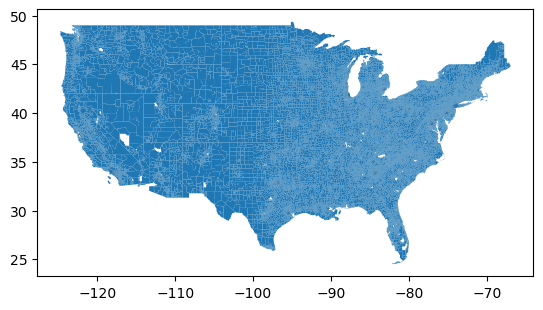

In [17]:
com_data.plot()

# Description Statistic Analysis

In [8]:
# Select the specified columns for correlation
descriptive_stats_columns = [
                            'log_gini_index','Gini_index',                                                                          # income inequality
                            'black_ra', 'hispan_ra',                                                                                # race
                            'ba_higher_ra',                                                                                         # educational attainment
                            'log_per_inc',                                                                                          # income level
                            'laborforce_partici_ra', 'unemply_ra',                                                                  # unemployment
                            'sinfami_ra',                                                                                           # household type
                            'fore_born_ra',                                                                                         # foreign born and native american
                            'log_popden',                                                                                           # pop density
                            'race_sdi']                                                                                             # diversity

In [9]:
import pandas as pd

description = com_data[descriptive_stats_columns].describe()
skewness = com_data[descriptive_stats_columns].skew().to_frame().transpose()
skewness.index = ['skew']
kurtosis = com_data[descriptive_stats_columns].kurt().to_frame().transpose()
kurtosis.index = ['kurt']

description = pd.concat([description, skewness, kurtosis], axis=0)
description

,log_gini_index,Gini_index,black_ra,hispan_ra,ba_higher_ra,log_per_inc,laborforce_partici_ra,unemply_ra,sinfami_ra,fore_born_ra,log_popden,race_sdi
count,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000,82660.0000
mean,-0.8810,0.4200,0.1339,0.1730,0.3245,10.4185,0.6297,0.0581,0.1781,0.1275,6.1749,0.3770
std,0.1663,0.0689,0.2106,0.2192,0.1985,0.4614,0.1071,0.0464,0.1038,0.1375,2.1317,0.2144
min,-4.7795,0.0084,0.0000,0.0000,0.0000,6.7166,0.0010,0.0000,0.0000,0.0000,-4.8177,0.0000
25%,-0.9840,0.3738,0.0084,0.0287,0.1694,10.1274,0.5720,0.0270,0.1031,0.0263,4.8639,0.1858
50%,-0.8824,0.4138,0.0416,0.0815,0.2768,10.3986,0.6390,0.0470,0.1571,0.0758,6.7545,0.3751
75%,-0.7774,0.4596,0.1549,0.2205,0.4479,10.6977,0.6990,0.0760,0.2333,0.1837,7.6386,0.5574
max,-0.1274,0.8804,1.0000,1.0000,1.0000,12.8183,1.0000,0.9380,0.9399,0.8852,11.6931,0.9644
skew,-0.7346,0.5168,2.2541,1.8603,0.7981,0.1220,-0.7955,2.2147,1.0389,1.5854,-0.7673,0.0683
kurt,11.4568,1.1619,4.6317,2.8778,-0.0989,1.0108,2.2178,10.2649,1.2930,2.3711,0.2216,-1.1533


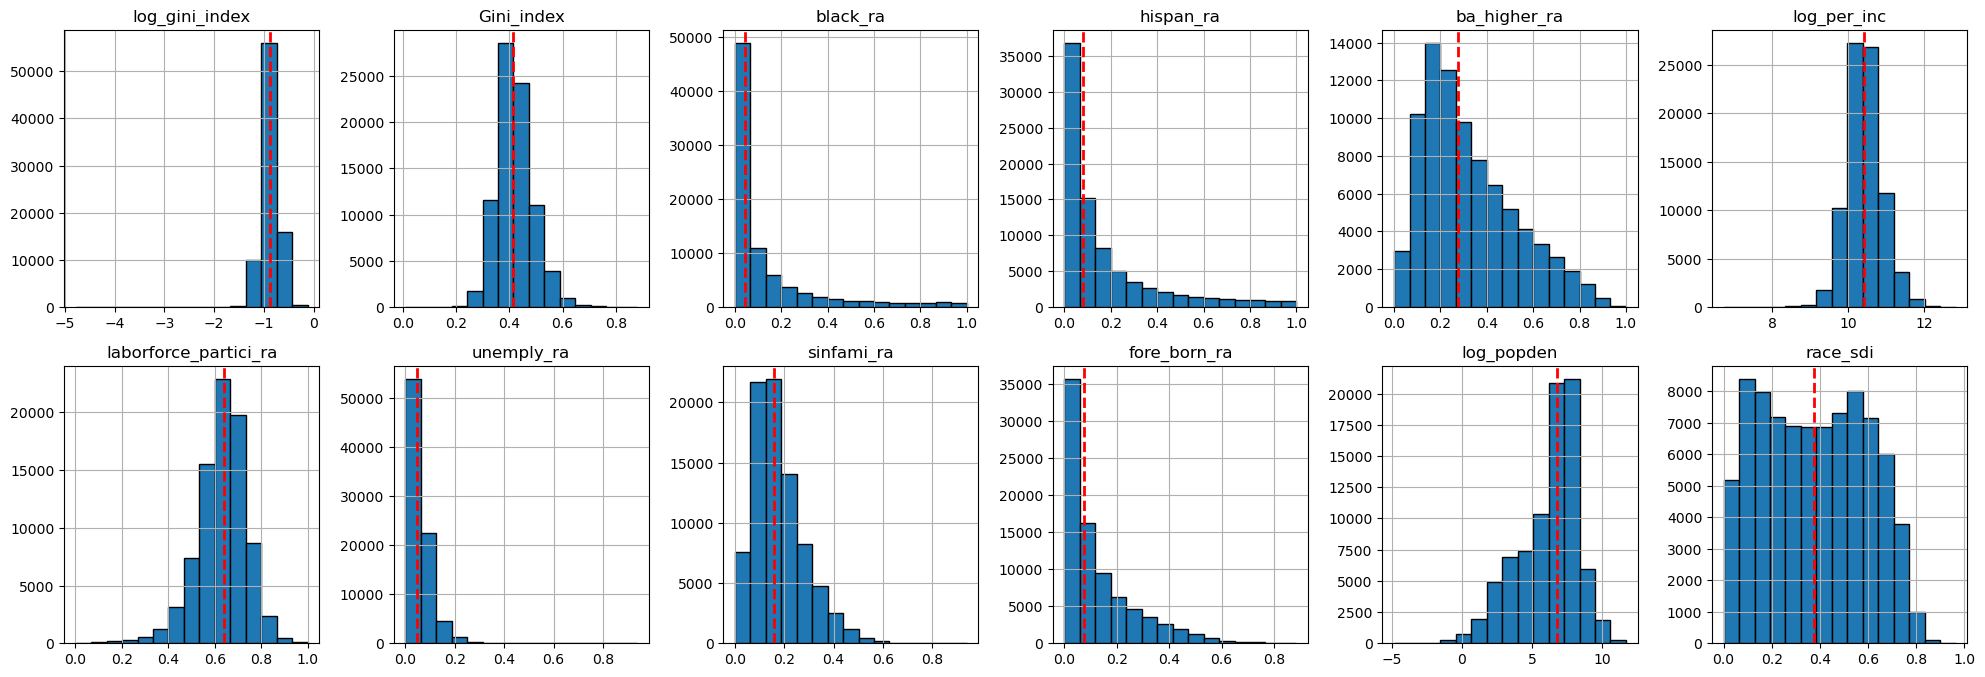

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))

for ax, column in zip(axes.flatten(), descriptive_stats_columns):
    com_data[column].hist(bins=15, edgecolor='black', ax=ax)
    
    median_val = com_data[column].median()
    ax.axvline(median_val, color='red', linestyle='dashed', linewidth=2)

    ax.set_title(column)

for ax in axes.flatten()[len(descriptive_stats_columns):]:
    ax.remove()
    
plt.tight_layout()
plt.show()

In [7]:
# Select the specified columns for correlation
independent_vars = [
                    'black_ra', 'hispan_ra',                                                                                # race
                    'ba_higher_ra',                                                                                         # educational attainment
                    'log_per_inc',                                                                                          # income level
                    'laborforce_partici_ra', 'unemply_ra',                                                                  # unemployment
                    'sinfami_ra',                                                                                           # household type
                    'fore_born_ra',                                                                                         # foreign born and native american
                    'log_popden',                                                                                           # pop density
                    'race_sdi']                                                                                             # diversity

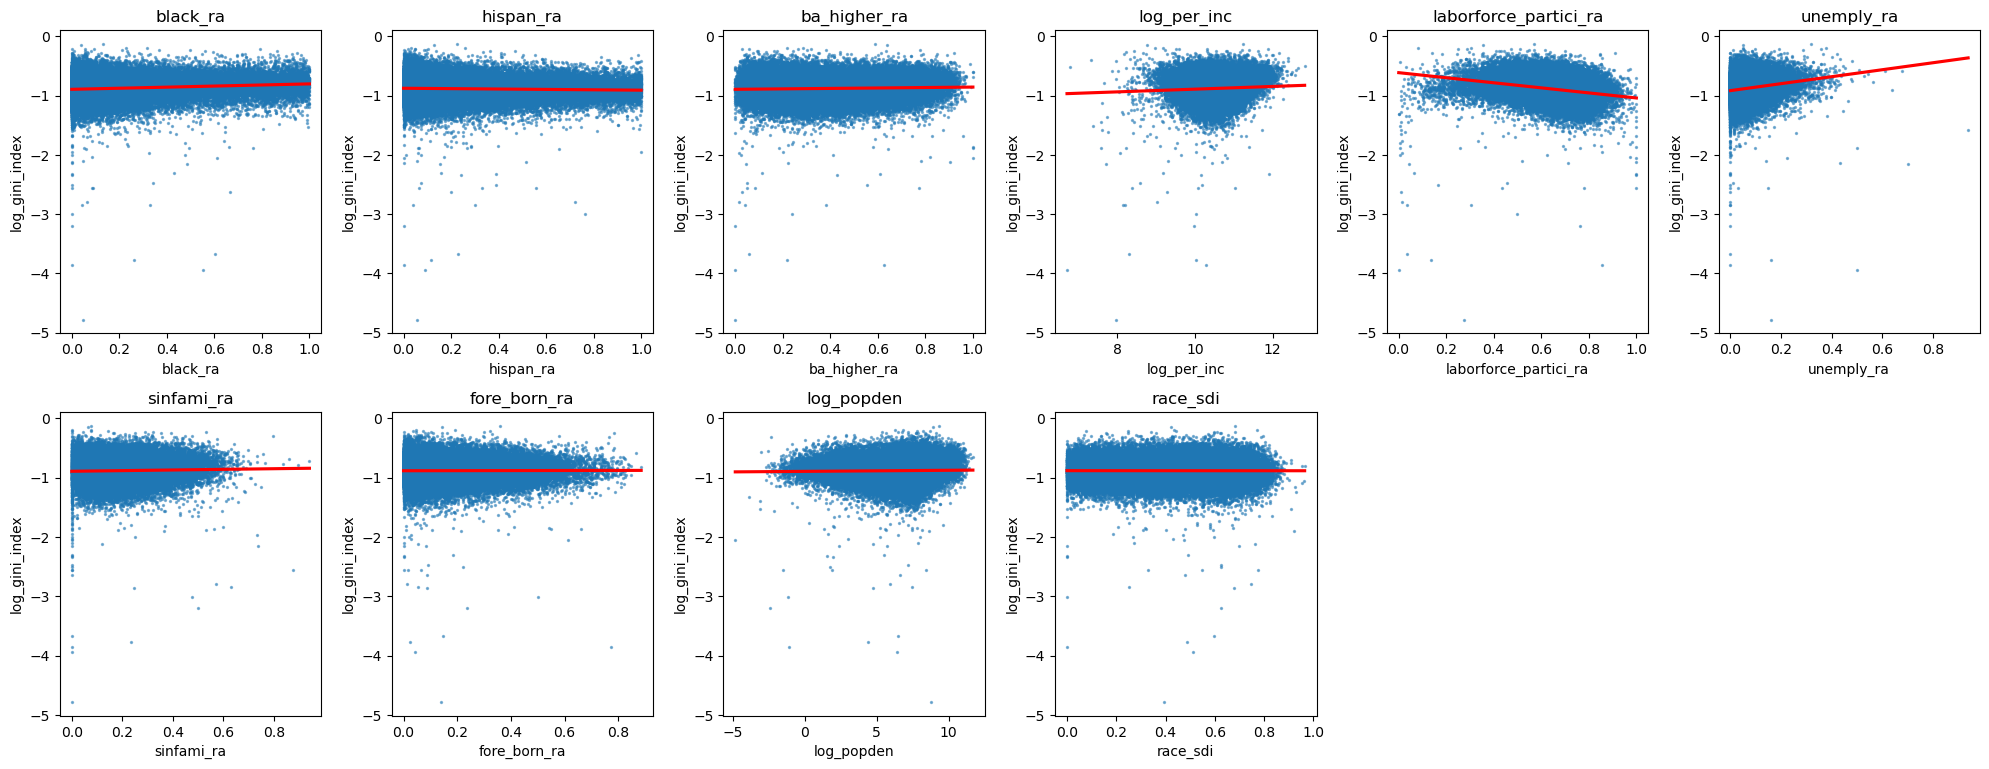

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
rows = 4
cols = 6

for index, var in enumerate(independent_vars):
    plt.subplot(rows, cols, index + 1)
    sns.regplot(x=var, y='log_gini_index', data=com_data, ci=None, 
                scatter_kws={'alpha':0.5, 's': 2, 'marker': '+'}, line_kws={'color': 'red'})
    plt.title(var)

plt.tight_layout()
plt.show()

## Check the Variance Inflation Factor(VIF)

In [13]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [14]:
# use the original variables
X = com_data[independent_vars] 

vif = calculate_vif(X)
print(vif)

                Variable     VIF
0               black_ra  2.6301
1              hispan_ra  4.2514
2           ba_higher_ra  8.2568
3            log_per_inc 48.5427
4  laborforce_partici_ra 46.7972
5             unemply_ra  3.2665
6             sinfami_ra  9.3049
7           fore_born_ra  4.2694
8             log_popden 17.9254
9               race_sdi  8.8624


## Check Corelationship

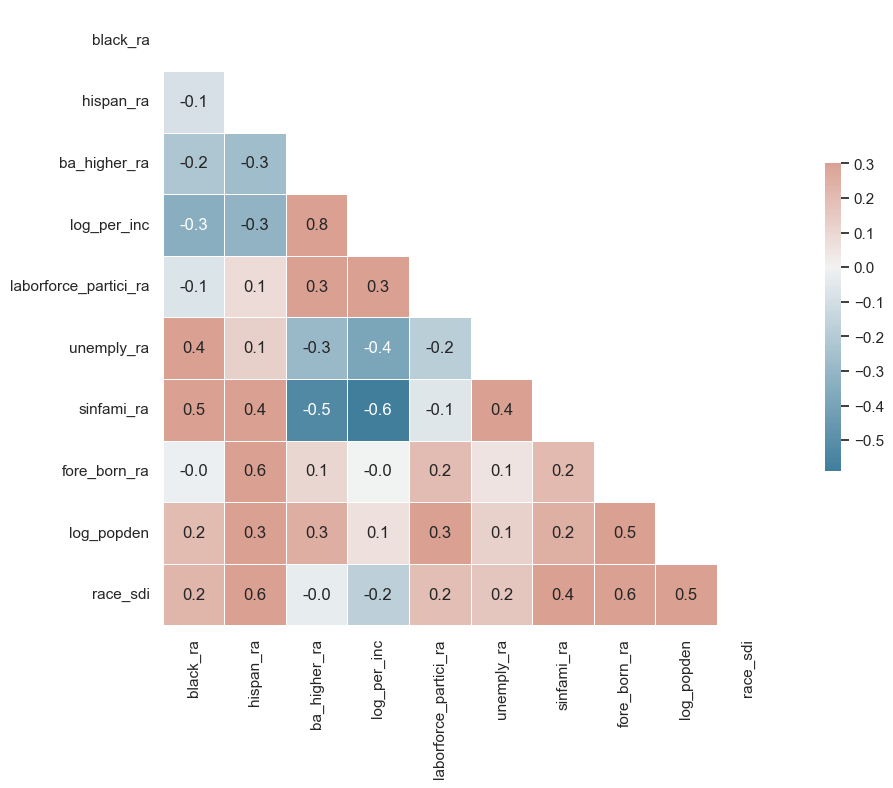

In [15]:
import seaborn as sns

sns.set_theme(style="white")

data_corr = com_data[independent_vars] 

# Compute the correlation matrix for the selected columns
corr = data_corr.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1f")

# Show the plot
plt.show()

# Create the Catogory Variable

# Run OLS Model

In [20]:
import statsmodels.api as sm

# Define Dependent and Indepent Variables
Y = com_data['log_gini_index']
X = com_data[independent_vars]                                                                       

# add constant
X = sm.add_constant(X)

# create ols model
ols_model = sm.OLS(Y, X).fit()
# ols_model = sm.OLS(Y, X).fit(cov_type='HC3')
# print results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_gini_index   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.162
Method:                 Least Squares   F-statistic:                     1603.
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:56:19   Log-Likelihood:                 38310.
No. Observations:               82660   AIC:                        -7.660e+04
Df Residuals:                   82649   BIC:                        -7.650e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.82

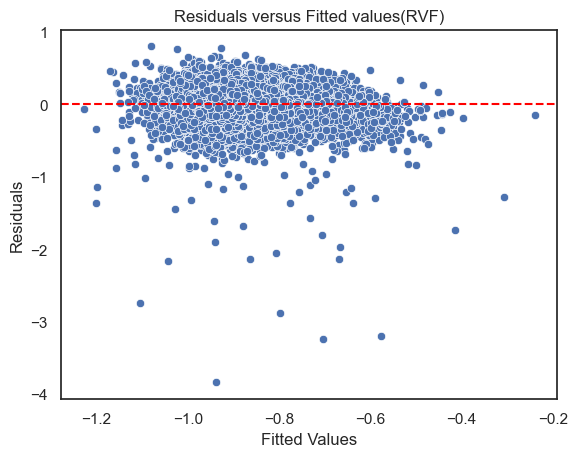

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# get the residuals
residuals = ols_model.resid

# gain the filting values
fitted = ols_model.fittedvalues

# plot residuals
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')  # 添加一条水平参考线
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals versus Fitted values(RVF)')
plt.show()

### Filtering the outlier row by Residuals

array([[<Axes: title={'center': 'residuals'}>]], dtype=object)

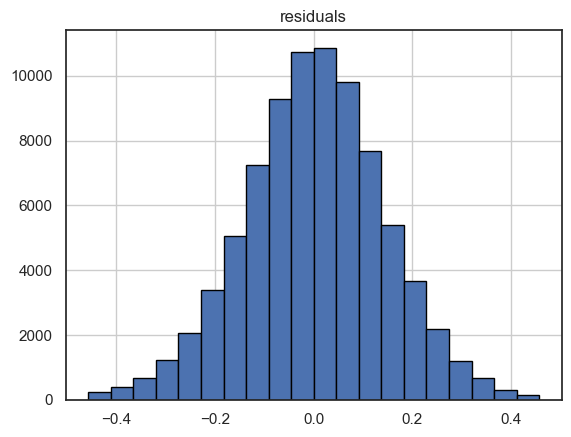

In [24]:
from scipy import stats

residuals = pd.DataFrame(residuals, columns=['residuals'])
residuals = residuals[(np.abs(stats.zscore(residuals))<3).all(axis=1)]

residuals.hist(bins=20, edgecolor='black')

In [25]:
print("Original DataFrame shape:", com_data.shape)
print("Filtered DataFrame shape:", residuals.shape)
print("Filted outlier:", com_data.shape[0] - residuals.shape[0])

Original DataFrame shape: (82660, 47)
Filtered DataFrame shape: (82181, 1)
Filted outlier: 479


In [26]:
filtered_com_data  = com_data[com_data.index.isin(residuals.index)]

In [37]:
import statsmodels.api as sm

# Define Dependent and Indepent Variables
Y = filtered_com_data['log_gini_index']
X = filtered_com_data[independent_vars]                                                                       

# add constant
X = sm.add_constant(X)

# create ols model
ols_model = sm.OLS(Y, X).fit()
# ols_model = sm.OLS(Y, X).fit(cov_type='HC3')
# print results
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:         log_gini_index   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1891.
Date:                Sun, 19 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:01:27   Log-Likelihood:                 43715.
No. Observations:               82181   AIC:                        -8.741e+04
Df Residuals:                   82170   BIC:                        -8.731e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -1.74

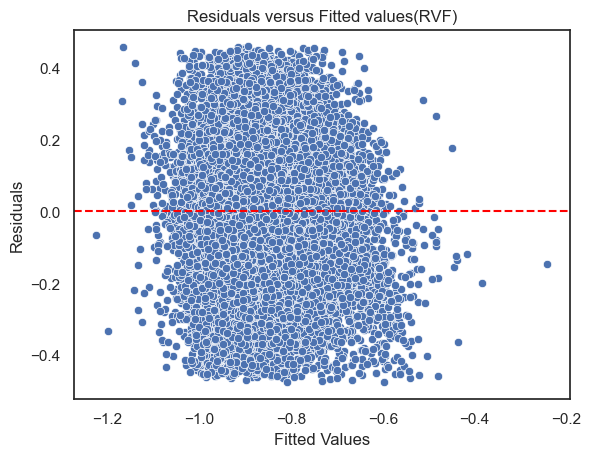

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# get the residuals
residuals = ols_model.resid

# gain the filting values
fitted = ols_model.fittedvalues

# plot residuals
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')  # 添加一条水平参考线
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals versus Fitted values(RVF)')
plt.show()

In [33]:
# filtered_com_data.to_file("filtered_com_data.shp")
# filtered_com_data.to_csv('filtered_com_data.csv',index=False)

In [8]:
filtered_com_data = gpd.read_file('filtered_com_data.shp')
filtered_com_data.columns = ['ALAND10','YEAR', 'STATE', 'COUNTY', 'Tract_name','GEO_ID', 'Gini_index', 'totalpop', 'white', 'black', 'amer_alska', 'asia', 'hawai_paci', 'some_other', 
                             'white_ra', 'black_ra', 'amer_alska_ra','asia_ra', 'hawai_paci_ra', 'some_other_ra', 'totaledu', 'less_high', 'high_equi', 'col', 'ba_higher', 'totaledu_ra', 'less_high_ra',
                             'high_equi_ra', 'col_ra', 'ba_higher_ra', 'per_inc', 'race_sdi', 'edu_sdi', 'hispan_ra', 'laborforce_partici_ra', 'employ_ra', 'unemply_ra', 'totalfami', 'sinfami', 'sinfami_ra', 
                             'fore_born_ra', 'nati_ameri_ra', 'popden', 'log_per_inc', 'log_popden', 'log_gini_index', 'geometry']
filtered_com_data.info()
filtered_com_data

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82181 entries, 0 to 82180
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   ALAND10                82181 non-null  float64 
 1   YEAR                   82181 non-null  object  
 2   STATE                  82181 non-null  object  
 3   COUNTY                 82181 non-null  object  
 4   Tract_name             82181 non-null  object  
 5   GEO_ID                 82181 non-null  object  
 6   Gini_index             82181 non-null  float64 
 7   totalpop               82181 non-null  float64 
 8   white                  82181 non-null  float64 
 9   black                  82181 non-null  float64 
 10  amer_alska             82181 non-null  float64 
 11  asia                   82181 non-null  float64 
 12  hawai_paci             82181 non-null  float64 
 13  some_other             82181 non-null  float64 
 14  white_ra               82181 n

,ALAND10,YEAR,STATE,COUNTY,Tract_name,GEO_ID,Gini_index,totalpop,white,black,amer_alska,asia,hawai_paci,some_other,white_ra,black_ra,amer_alska_ra,asia_ra,hawai_paci_ra,some_other_ra,totaledu,less_high,high_equi,col,ba_higher,totaledu_ra,less_high_ra,high_equi_ra,col_ra,ba_higher_ra,per_inc,race_sdi,edu_sdi,hispan_ra,laborforce_partici_ra,employ_ra,unemply_ra,totalfami,sinfami,sinfami_ra,fore_born_ra,nati_ameri_ra,popden,log_per_inc,log_popden,log_gini_index,geometry
0,19.2613,2017-2021,Alabama,Dale County,"Census Tract 208.01, Dale County, Alabama",01045020801,0.4533,3317.0000,2015.0000,788.0000,66.0000,12.0000,0.0000,286.0000,0.6075,0.2376,0.0199,0.0036,0.0000,0.0862,2249.0000,270.0000,703.0000,817.0000,292.0000,0.6780,0.1201,0.3126,0.3633,0.1298,25563.0000,0.5667,0.7391,0.1724,0.4720,0.4090,0.1210,1213.0000,321.0000,0.2646,0.0889,0.8915,172.2104,10.1489,5.1487,-0.7912,"POLYGON ((-85.70064 31.38509, -85.70043 31.385..."
1,62.9987,2017-2021,Alabama,Chambers County,"Census Tract 9542, Chambers County, Alabama",01017954200,0.4232,3800.0000,3008.0000,527.0000,0.0000,196.0000,0.0000,0.0000,0.7916,0.1387,0.0000,0.0516,0.0000,0.0000,2731.0000,356.0000,1050.0000,995.0000,305.0000,0.7187,0.1304,0.3845,0.3643,0.1117,26403.0000,0.3515,0.6900,0.0100,0.6450,0.6280,0.0270,1280.0000,202.0000,0.1578,0.0558,0.9442,60.3187,10.1812,4.0996,-0.8599,"POLYGON ((-85.31549 32.80580, -85.31354 32.808..."
2,515.6922,2017-2021,Alabama,Chambers County,"Census Tract 9538, Chambers County, Alabama",01017953800,0.3830,3715.0000,2674.0000,1018.0000,21.0000,0.0000,0.0000,1.0000,0.7198,0.2740,0.0057,0.0000,0.0000,0.0003,2895.0000,378.0000,1243.0000,929.0000,265.0000,0.7793,0.1306,0.4294,0.3209,0.0915,20447.0000,0.4068,0.6872,0.0059,0.4820,0.4700,0.0260,1512.0000,314.0000,0.2077,0.0000,1.0000,7.2039,9.9256,1.9746,-0.9597,"POLYGON ((-85.59345 33.00012, -85.59333 33.000..."
3,132.6425,2017-2021,Alabama,Chambers County,"Census Tract 9543, Chambers County, Alabama",01017954300,0.4237,5275.0000,2834.0000,2208.0000,0.0000,126.0000,0.0000,47.0000,0.5373,0.4186,0.0000,0.0239,0.0000,0.0089,3606.0000,366.0000,1199.0000,1269.0000,681.0000,0.6836,0.1015,0.3325,0.3519,0.1889,29490.0000,0.5355,0.7196,0.0095,0.5880,0.5800,0.0140,2081.0000,458.0000,0.2201,0.0317,0.9683,39.7685,10.2918,3.6831,-0.8587,"POLYGON ((-85.38077 32.78301, -85.37985 32.782..."
4,38.0368,2017-2021,Alabama,Chambers County,"Census Tract 9547, Chambers County, Alabama",01017954700,0.3657,4586.0000,3126.0000,1386.0000,26.0000,0.0000,0.0000,0.0000,0.6816,0.3022,0.0057,0.0000,0.0000,0.0000,3091.0000,378.0000,1139.0000,984.0000,488.0000,0.6740,0.1223,0.3685,0.3183,0.1579,23179.0000,0.4440,0.7230,0.0000,0.6070,0.5970,0.0170,1706.0000,490.0000,0.2872,0.0000,1.0000,120.5674,10.0510,4.7922,-1.0059,"POLYGON ((-85.22897 32.74543, -85.22894 32.745..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82176,2.0348,2017-2021,Wyoming,Laramie County,"Census Tract 10, Laramie County, Wyoming",56021001000,0.4848,3142.0000,2644.0000,52.0000,0.0000,56.0000,9.0000,125.0000,0.8415,0.0165,0.0000,0.0178,0.0029,0.0398,2218.0000,167.0000,575.0000,775.0000,690.0000,0.7059,0.0753,0.2592,0.3494,0.3111,36829.0000,0.2897,0.7083,0.1572,0.7360,0.6730,0.0630,1495.0000,205.0000,0.1371,0.0729,0.9169,1544.1344,10.5140,7.3422,-0.7240,"POLYGON ((-104.84487 41.13908, -104.84384 41.1..."
82177,2.8191,2017-2021,Wyoming,Natrona County,"Census Tract 4, Natrona County, Wyoming",56025000400,0.3374,3936.0000,3809.0000,0.0000,5.0000,8.0000,0.0000,16.0000,0.9677,0.0000,0.0013,0.0020,0.0000,0.0041,2807.0000,122.0000,933.0000,1231.0000,469.0000,0.7132,0.0435,0.3324,0.4385,0.1671,31717.0000,0.0635,0.6674,0.0655,0.7360,0.7030,0.0450,1756.0000,290.0000,0.1651,0.0267,0.9710,1396.1789,10.3646,7.2415,-1.0865,"POLYGON ((-106.29809 42.85011, -106.29808 42.8..."
82178,3.8051,2017-2021,Wyoming,Natrona County,"Census Tract 8, 

<Axes: >

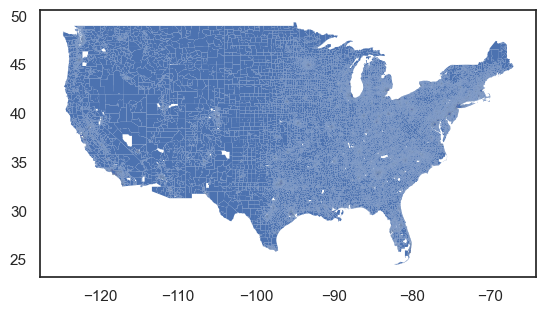

In [35]:
filtered_com_data.plot(linewidth=0)

# Run Lasso Model

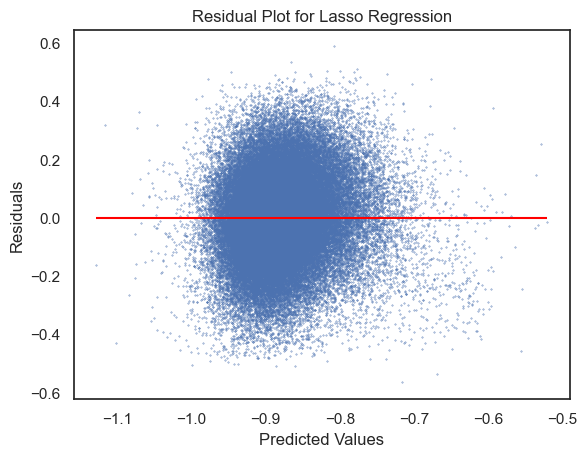

In [36]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import statsmodels.api as sm

Y = filtered_com_data['log_gini_index']
X = filtered_com_data[independent_vars]
X = sm.add_constant(X)

# Create the lasso model
lasso_model = Lasso(alpha=0.001)  # change the strength of regularization
lasso_model.fit(X, Y)

# calculate the residuals
predicted = lasso_model.predict(X)
residuals = Y - predicted

# create the residual plot
plt.scatter(predicted, residuals, s=0.1)
plt.hlines(y=0, xmin=predicted.min(), xmax=predicted.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Lasso Regression')
plt.show()

In [37]:
r2_score = lasso_model.score(X, Y)
print("R^2 Score: ", r2_score)

coefficients = lasso_model.coef_
print("Coefficients: ", coefficients)

intercept = lasso_model.intercept_
print("Intercept: ", intercept)

non_zero_coefficients = {independent_vars[i]: coefficients[i] for i in range(len(coefficients)) if coefficients[i] != 0}
print("Non-zero Coefficients: ", non_zero_coefficients)

R^2 Score:  0.15293079826205347
Coefficients:  [ 0.          0.09284806  0.00206836  0.          0.06609459 -0.48265883
  0.00283853  0.          0.          0.00596072  0.        ]
Intercept:  -1.313483982029826
Non-zero Coefficients:  {'hispan_ra': 0.09284805510800287, 'ba_higher_ra': 0.002068362453228632, 'laborforce_partici_ra': 0.06609459468052709, 'unemply_ra': -0.4826588343740968, 'sinfami_ra': 0.002838527223259035, 'race_sdi': 0.005960722463640165}


# Run Ridge Model

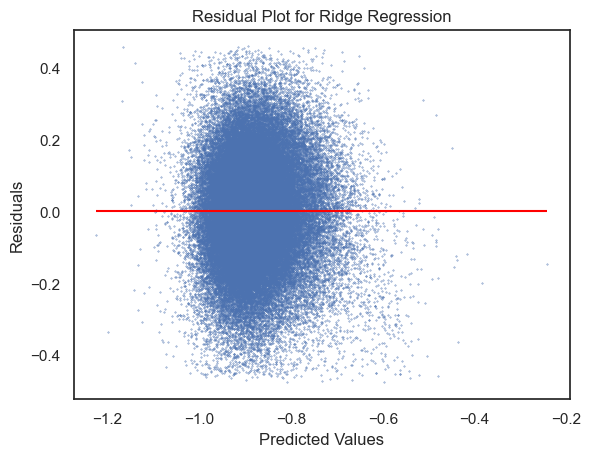

In [38]:
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import statsmodels.api as sm

Y = filtered_com_data['log_gini_index']
X = filtered_com_data[independent_vars]
X = sm.add_constant(X)

# create the ridge model
ridge_model = Ridge(alpha=0.1)  
ridge_model.fit(X, Y)

# calcualte the residual
predicted = ridge_model.predict(X)
residuals = Y - predicted

# create the residual plot
plt.scatter(predicted, residuals, s=0.1)
plt.hlines(y=0, xmin=predicted.min(), xmax=predicted.max(), colors='red')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Ridge Regression')
plt.show()

In [39]:
r2_score = ridge_model.score(X, Y)
print("R^2 Score: ", r2_score)

intercept = ridge_model.intercept_
print("Intercept: ", intercept)

coefficients = ridge_model.coef_
variable_names = independent_vars

coefficient_dict = dict(zip(variable_names, coefficients))
print("Coefficients by Variable: ")
for variable, coefficient in coefficient_dict.items():
    print(f"{variable}: {coefficient}")

R^2 Score:  0.1870624621172956
Intercept:  -1.747876466808631
Coefficients by Variable: 
black_ra: 0.0
hispan_ra: 0.08818091267212884
ba_higher_ra: 0.030470535941655778
log_per_inc: 0.036454879047906646
laborforce_partici_ra: 0.11004498445246805
unemply_ra: -0.5958432863857652
sinfami_ra: 0.5469029433421054
fore_born_ra: 0.11742818183043445
log_popden: 0.017845187262399413
race_sdi: 0.0016495732826610067


# Check Spatial Autocorrelation

In [41]:
import pysal 
import mapclassify
from pysal.explore import esda
from pysal.lib import weights

## Create Spatial Weight Matrix and Moran I's Test

In [42]:
# Create spatial wegith by "Queen"
w_queen = weights.contiguity.Queen.from_dataframe(filtered_com_data)
w_queen.transform = 'R'
moran_queen = esda.moran.Moran(filtered_com_data['log_gini_index'], w_queen)
print("Queen's Moran's I:", moran_queen.I)
print("Queen's p-value:", moran_queen.p_sim)

('WARNING: ', 7098, ' is an island (no neighbors)')
('WARNING: ', 29994, ' is an island (no neighbors)')
('WARNING: ', 37736, ' is an island (no neighbors)')
('WARNING: ', 39050, ' is an island (no neighbors)')
('WARNING: ', 49127, ' is an island (no neighbors)')
('WARNING: ', 51883, ' is an island (no neighbors)')
('WARNING: ', 65017, ' is an island (no neighbors)')
('WARNING: ', 65210, ' is an island (no neighbors)')
Queen's Moran's I: 0.2825855658847207
Queen's p-value: 0.001


In [42]:
filtered_com_data["log_gini_index_lag"] = weights.spatial_lag.lag_spatial(w_queen, filtered_com_data['log_gini_index'])

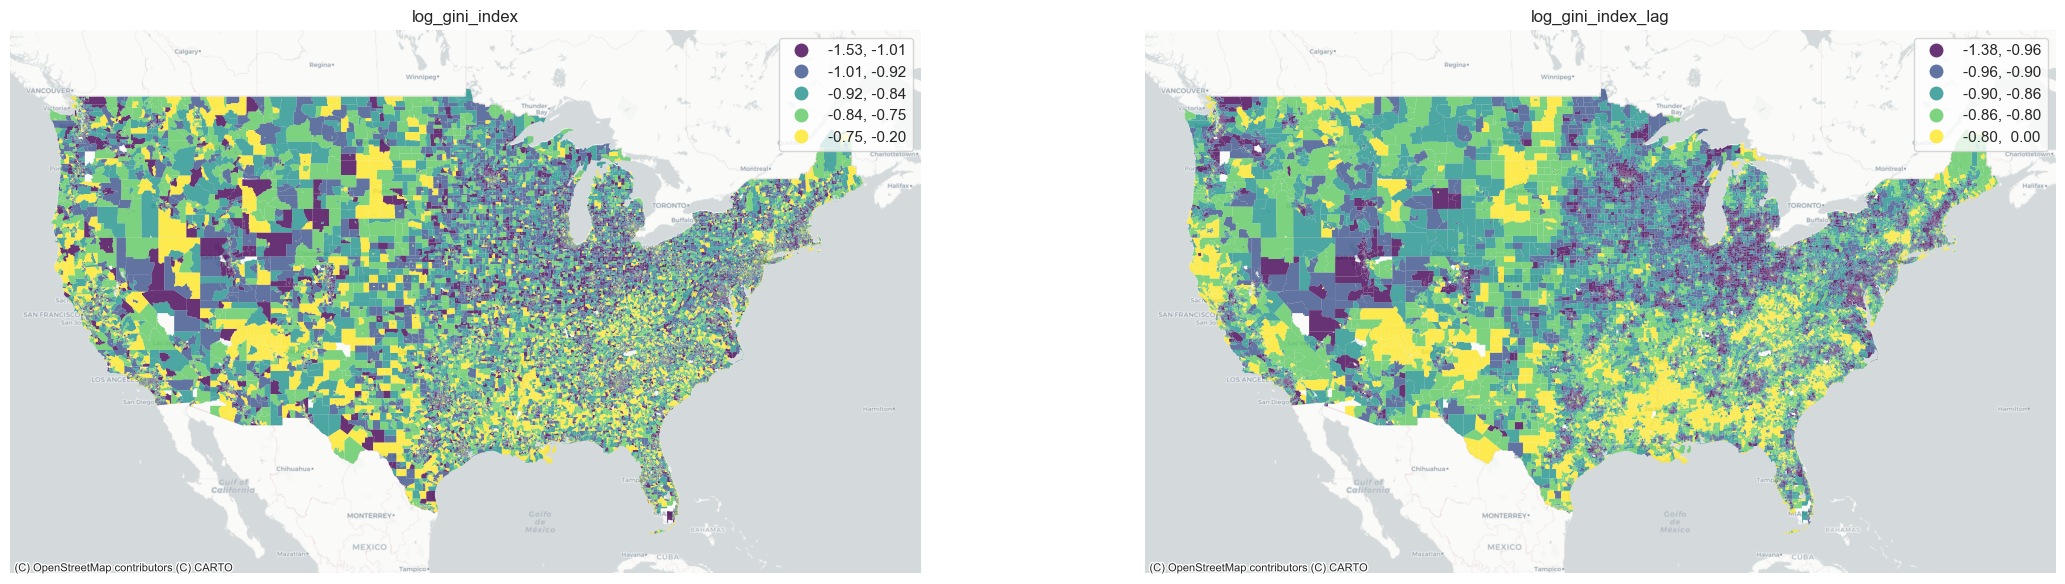

In [43]:
visual_com_data = filtered_com_data.to_crs(epsg=3857)

import contextily as ctx

f, axs = plt.subplots(1, 2, figsize=(24,6))

ax1, ax2 = axs

visual_com_data.plot(
        column="log_gini_index",
        cmap="viridis",
        scheme="quantiles",
        k=5,
        alpha=0.8,
        legend=True,
        linewidth=0,
        ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("log_gini_index")
ctx.add_basemap(
    ax1,
    crs=visual_com_data.crs,
    source=ctx.providers.CartoDB.Positron,
)
# visualize the mainland of US in epsg3857
ax1.set_xlim([-14200000, -7000000])
ax1.set_ylim([2500000, 6800000])


visual_com_data.plot(
        column="log_gini_index_lag",
        cmap="viridis",
        scheme="quantiles",
        k=5,
        alpha=0.8,
        legend=True,
        linewidth=0,
        ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("log_gini_index_lag")
ctx.add_basemap(
    ax2,
    crs=visual_com_data.crs,
    source=ctx.providers.CartoDB.Positron,
)
ax2.set_xlim([-14200000, -7000000])
ax2.set_ylim([2500000, 6800000])

plt.subplots_adjust(wspace=0.1)
plt.tight_layout()

plt.savefig('Spatial Autocorrelation Visulaization.png', dpi=300, bbox_inches='tight')
plt.show()

## Run Spatial Lag Model

In [43]:
import statsmodels.formula.api as smf
from pysal.model import spreg

y = filtered_com_data['log_gini_index']
X = filtered_com_data[independent_vars]

slm_model = spreg.GM_Lag(y.values, X.values, w=w_queen, name_y='log_gini_index', name_x=independent_vars)

print(slm_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_gini_index                Number of Observations:       82181
Mean dependent var  :     -0.8791                Number of Variables   :          12
S.D. dependent var  :      0.1577                Degrees of Freedom    :       82169
Pseudo R-squared    :      0.2952
Spatial Pseudo R-squared:  0.1705

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT        -1.50004         0.02062       -72.75427         0.00000
            black_ra         0.05863         0.00315        18.64308         0.00000
           hispan_ra         0.02029    

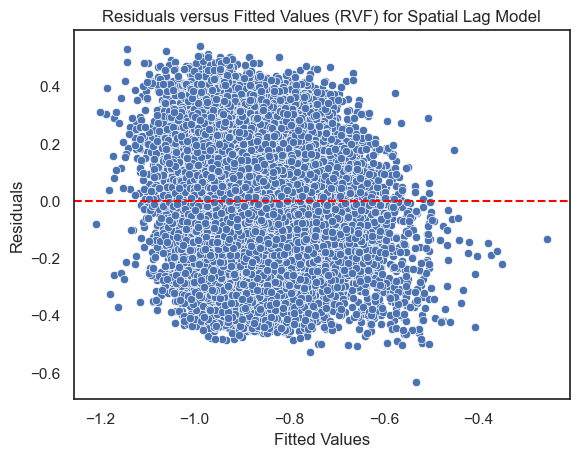

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt


slm_residuals = slm_model.e_pred.ravel()  
slm_fitted = slm_model.predy_e.ravel()               

sns.scatterplot(x=slm_fitted, y=slm_residuals)
plt.axhline(y=0, color='red', linestyle='--') 
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals versus Fitted Values (RVF) for Spatial Lag Model')
plt.show()

# Explore the Spatial Heterogeneity

In [9]:
state_titles_to_use = filtered_com_data['STATE'].unique().tolist()
len(state_titles_to_use)

49

## Standardlize Processing:[(x-u)/sd] for Selected Independent Variables in each selected State area

In [46]:
# from sklearn.preprocessing import StandardScaler

# com_data_copy = pd.DataFrame()
# com_data_copy = filtered_com_data.copy()

# # Create scaler indicator
# scaler = StandardScaler()

# for state_title in state_titles_to_use:
#     # matching selected list with dataframe
#     select_data = com_data_copy['STATE'] == state_title
#     # processing scaler processing
#     com_data_copy.loc[select_data, selected_independent_vars] = scaler.fit_transform(com_data_copy.loc[select_data, selected_independent_vars])

In [47]:
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

# for ax, column in zip(axes.flatten(), selected_independent_vars):
#     com_data_copy[column].hist(bins=15, edgecolor='black', ax=ax)
    
#     median_val = com_data_copy[column].median()
#     ax.axvline(median_val, color='red', linestyle='dashed', linewidth=2)

#     ax.set_title(column)

# for ax in axes.flatten()[len(selected_independent_vars):]:
#     ax.remove()
    
# plt.tight_layout()
# plt.show()

## Run GWR Model

In [10]:
com_data_copy = filtered_com_data.to_crs(epsg=3857)

com_data_copy['centroid'] = com_data_copy['geometry'].centroid
com_data_copy['lat'] = com_data_copy['centroid'].y
com_data_copy['lon'] = com_data_copy['centroid'].x

In [12]:
import pandas as pd
import numpy as np

accumulated_gwr_filtered_t = pd.DataFrame()
gwr_filtered_t = pd.DataFrame()
successful_states = []  # List to keep track of successfully processed States
failed_states = []
gwr_columns = ['gwr_intercept', 'gwr_black_ra', 'gwr_hispan_ra', 'gwr_ba_higher_ra', 'gwr_log_per_inc','gwr_laborforce_partici_ra', 'gwr_unemply_ra', 'gwr_sinfami_ra', 
               'gwr_fore_born_ra', 'gwr_log_popden', 'gwr_race_sdi']

# Iterate over all filtered CSA Titles
for state_title in state_titles_to_use:
    try:
        # Determine selected CSA
        select_state = com_data_copy[com_data_copy['STATE'] == state_title]
        
        # Selecting the dependent & independent variables
        y = select_state['log_gini_index'].values.reshape((-1, 1))
        X = select_state[independent_vars].values
        
        # Define the coordinates
        u = select_state['lon']
        v = select_state['lat']
        coords = list(zip(u, v))
        
        # selecting the GWR Bandwidth
        gwr_selector = Sel_BW(coords, y, X)
        gwr_bw = gwr_selector.search()
        print(f'GWR bandwidth for {state_title} =', gwr_bw)

        # fit the GWR Model
        gwr_results = GWR(coords, y, X, gwr_bw).fit()

        # Adding local R² to the selected CSA dataframe
        select_state['gwr_R2'] = gwr_results.localR2
        
        # Adding GWR coefficients to the dataframe
        for i, name in enumerate(gwr_columns):
            select_state[name] = gwr_results.params[:, i]

        # # Generate predictions using the GWR model
        # select_state['gwr_predictions'] = gwr_results.predict(coords, X).predictions
        
        # Filtering the t-value with a significant alpha level of 0.05
        gwr_filtered_t = gwr_results.filter_tvals(alpha=0.1)
        gwr_filtered_t = pd.DataFrame(gwr_filtered_t, index=select_state.index, columns=gwr_columns)
        gwr_filtered_t['STATE'] = state_title
        accumulated_gwr_filtered_t = pd.concat([accumulated_gwr_filtered_t, gwr_filtered_t])

        # Combine results into the dataframe
        com_data_copy.loc[select_state.index, select_state.columns] = select_state

        # Add the successful CSA to the list
        successful_states.append(state_title)

    except np.linalg.LinAlgError as e:  # Numpy error raised when there is a problem with linear algebra calculations, like a singular matrix.
        failed_states.append(f"{state_title} - linear algebra issue: {e}")
        continue  # Skip the rest of the loop and proceed with the next iteration.
    
    except ValueError as e:
        # This block handles value errors, such as data type mismatches or indexing problems.
        failed_states.append(f"{state_title} - Value error: {e}")
        continue
    
    except Exception as e:
        # This block catches all other types of exceptions.
        failed_states.append(f"{state_title} - Other error: {e}")
        continue

# At the end, print out the list of successful CSAs
print("Successfully processed States:")
for state in successful_states:
    print(state)

print("-------------------------------------")

if failed_states:  
    print("Failed processed States:")
    for state in failed_states:
        print(state)
else:
    print("No States processing failed.")

print("-------------------------------------")

# check if the index of accumulated_gwr_filtered_t were included by com_data_copy index
index_check = accumulated_gwr_filtered_t.index.isin(com_data_copy.index)
print(index_check.all())

print("-------------------------------------")
# check is there any duplicated index in com_data_copy
segregation_duplicates = com_data_copy.index.duplicated()
if segregation_duplicates.any():
    print("'com_data_copy' has the duplicated index.")
else:
    print("'com_data_copy' has not the duplicated index.")

# check is there any duplicated index in accumulated_gwr_filtered_t
accumulated_duplicates = accumulated_gwr_filtered_t.index.duplicated()
if accumulated_duplicates.any():
    print("'accumulated_gwr_filtered_t' has the duplicated index.")
else:
    print("'accumulated_gwr_filtered_t' has not the duplicated index.")

print("-------------------------------------")
print(f"'com_data_copy' has {com_data_copy['gwr_intercept'].notnull().sum()} new values.")
print(f"'accumulated_gwr_filtered_t' has {accumulated_gwr_filtered_t['gwr_intercept'].notnull().sum()} new values.")

GWR bandwidth for Alabama = 329.0
GWR bandwidth for Arizona = 209.0
GWR bandwidth for Arkansas = 502.0
GWR bandwidth for California = 273.0
GWR bandwidth for Colorado = 253.0
GWR bandwidth for Connecticut = 214.0
GWR bandwidth for Delaware = 120.0
GWR bandwidth for District of Columbia = 176.0
GWR bandwidth for Florida = 251.0
GWR bandwidth for Georgia = 282.0
GWR bandwidth for Idaho = 353.0
GWR bandwidth for Illinois = 356.0
GWR bandwidth for Indiana = 411.0
GWR bandwidth for Iowa = 761.0
GWR bandwidth for Kansas = 205.0
GWR bandwidth for Kentucky = 230.0
GWR bandwidth for Louisiana = 486.0
GWR bandwidth for Maine = 271.0
GWR bandwidth for Maryland = 270.0
GWR bandwidth for Massachusetts = 330.0
GWR bandwidth for Michigan = 316.0
GWR bandwidth for Minnesota = 202.0
GWR bandwidth for Mississippi = 307.0
GWR bandwidth for Missouri = 236.0
GWR bandwidth for Montana = 316.0
GWR bandwidth for Nebraska = 317.0
GWR bandwidth for Nevada = 241.0
GWR bandwidth for New Hampshire = 170.0
GWR band

In [13]:
# reindex the accumulated_gwr_filtered_t
accumulated_gwr_filtered_t_state_apt = accumulated_gwr_filtered_t.reindex(com_data_copy.index)

In [14]:
# Iterate over each column and row in accumulated_gwr_filtered_t_state_apt
for column in accumulated_gwr_filtered_t_state_apt.columns:
    for idx in accumulated_gwr_filtered_t_state_apt.index:
        # Check if the value in accumulated_gwr_filtered_t_state_apt is 0 or NAN
        if accumulated_gwr_filtered_t_state_apt.at[idx, column] == 0 or pd.isna(accumulated_gwr_filtered_t_state_apt.at[idx, column]):
            # If the value is 0, set the corresponding value in accumulated_gwr_filtered_t_state_apt to NaN
            com_data_copy.at[idx, column] = np.nan

In [ ]:
# com_data_copy['residuals'] = com_data_copy['log_gini_index'] - com_data_copy['gwr_predictions']

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt              

# sns.scatterplot(x=com_data_copy['gwr_predictions'], y=com_data_copy['residuals'])
# plt.axhline(y=0, color='red', linestyle='--') 
# plt.xlabel('Fitted Values')
# plt.ylabel('Residuals')
# plt.title('Residuals versus Fitted Values (RVF) for Spatial Lag Model')
# plt.show()

In [15]:
columns_to_compare = ['gwr_R2'] + gwr_columns

In [16]:
import pandas as pd

description = com_data_copy[columns_to_compare].describe()
skewness = com_data_copy[columns_to_compare].skew().to_frame().transpose()
skewness.index = ['skew']
kurtosis = com_data_copy[columns_to_compare].kurt().to_frame().transpose()
kurtosis.index = ['kurt']

description = pd.concat([description, skewness, kurtosis], axis=0)
description

,gwr_R2,gwr_intercept,gwr_black_ra,gwr_hispan_ra,gwr_ba_higher_ra,gwr_log_per_inc,gwr_laborforce_partici_ra,gwr_unemply_ra,gwr_sinfami_ra,gwr_fore_born_ra,gwr_log_popden,gwr_race_sdi
count,82181.0000,78989.0000,39600.0000,25072.0000,30623.0000,72898.0000,79245.0000,49684.0000,22307.0000,24301.0000,31403.0000,22718.0000
mean,0.3735,-2.9236,0.3183,0.2298,-0.1675,0.2309,-0.6440,0.7480,0.3302,0.2839,0.0251,0.1019
std,0.0950,1.0459,0.4667,0.3992,0.3007,0.0935,0.2000,0.2846,0.2674,0.5253,0.0242,0.2253
min,0.0896,-9.3647,-3.1102,-2.0192,-1.9841,-0.1469,-1.5974,-1.2382,-0.7070,-2.2061,-0.0624,-0.6195
25%,0.3061,-3.5724,0.1614,0.1874,-0.3677,0.1651,-0.7671,0.5565,0.2769,0.1760,0.0164,-0.1539
50%,0.3702,-2.8296,0.2681,0.2992,-0.2602,0.2211,-0.6369,0.6978,0.3620,0.3525,0.0269,0.1814
75%,0.4362,-2.2131,0.4280,0.4313,0.1712,0.2861,-0.5061,0.9018,0.4676,0.5355,0.0394,0.2453
max,0.7910,1.0372,3.8432,1.3471,0.7492,0.8436,0.3653,3.2754,1.4704,2.8672,0.1162,0.9027
skew,0.1950,-0.4545,0.5274,-1.1877,0.4299,0.5472,-0.3378,0.9517,-1.3196,0.0077,-0.5548,-0.6790
kurt,-0.2185,0.0835,6.5079,1.9546,-0.6501,0.4868,0.1316,5.7261,2.2506,2.1569,0.8583,-0.5084


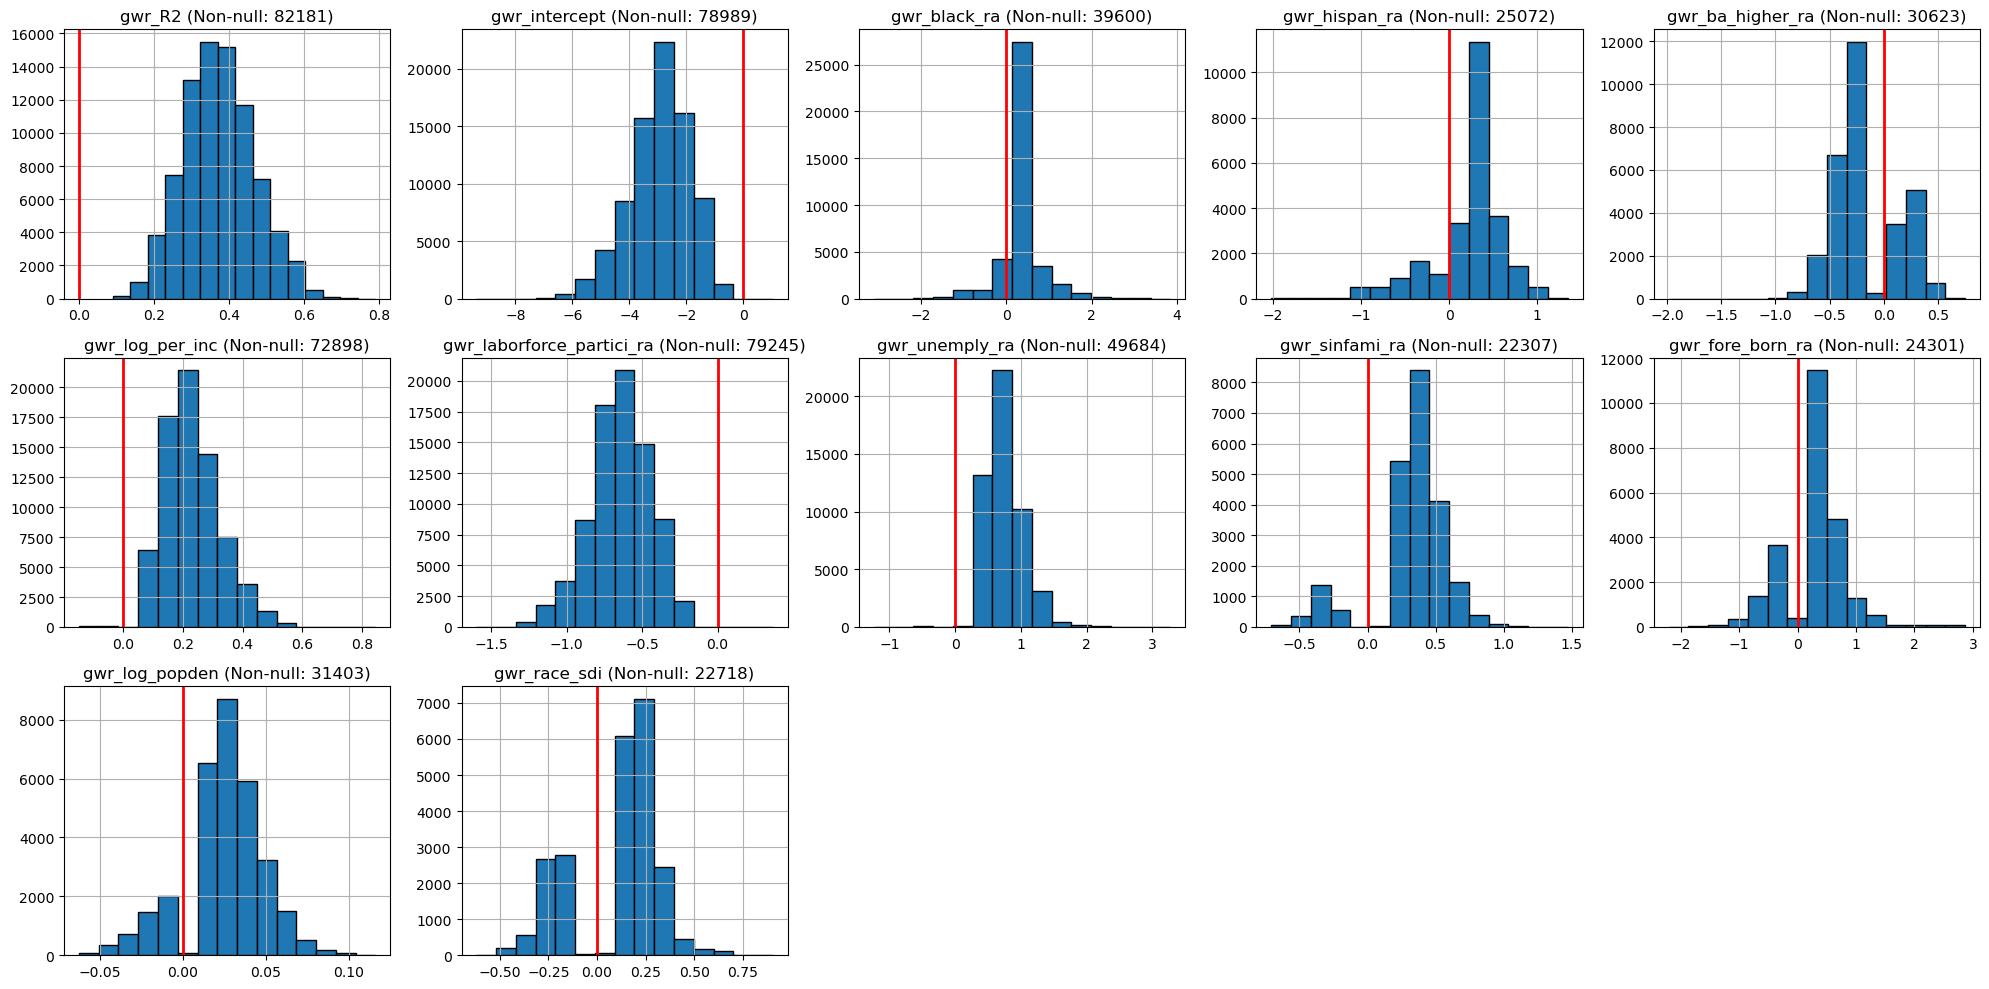

In [17]:
# Plot histograms for all columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 10))

for ax, column in zip(axes.flatten(), columns_to_compare):
    com_data_copy[column].hist(bins=15, edgecolor='black', ax=ax)
    
    non_null_count = com_data_copy[column].notnull().sum()
    ax.axvline(x=0, color='red', linewidth=2)

    ax.set_title(f'{column} (Non-null: {non_null_count})')

for ax in axes.flatten()[len(columns_to_compare):]:
    ax.remove()
    
plt.tight_layout()  
plt.show()

In [55]:
com_data_copy = com_data_copy.drop(columns='centroid')
com_data_copy.to_file("com_data_copy.shp")

In [56]:
com_data_copy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 82181 entries, 0 to 82180
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   ALAND10                    82181 non-null  float64 
 1   YEAR                       82181 non-null  object  
 2   STATE                      82181 non-null  object  
 3   COUNTY                     82181 non-null  object  
 4   Tract_name                 82181 non-null  object  
 5   GEO_ID                     82181 non-null  object  
 6   Gini_index                 82181 non-null  float64 
 7   totalpop                   82181 non-null  float64 
 8   white                      82181 non-null  float64 
 9   black                      82181 non-null  float64 
 10  amer_alska                 82181 non-null  float64 
 11  asia                       82181 non-null  float64 
 12  hawai_paci                 82181 non-null  float64 
 13  some_other             